# Yusei Kikuchi: The Evolution of a Left-Handed Pitcher (2019-2025)

**菊池雄星の投球変化を追う: マリナーズ→ブルージェイズ→アストロズ→エンジェルス**

- 2019-2021 (Mariners): MLB挑戦と試行錯誤
- 2022-2024前半 (Blue Jays): 安定を求めて
- 2024後半 (Astros): スライダー革命と覚醒
- 2025 (Angels): ローテーション確立、33先発

キャリアを通じた球種配分・球速・変化量・空振り率の変遷を分析

※ 本ノートブックはStatcastデータから読み取れる傾向の紹介であり、本人の意図について断定するものではありません

---

---

**Data Source:**
[Japanese MLB Players Statcast (2015-2025)](https://www.kaggle.com/datasets/yasunorim/japan-mlb-pitchers-batters-statcast) - 34 Japanese MLB players, 174k pitches+hits, 10.0/10 score 🏆


In [1]:
!pip install pybaseball duckdb -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.7/432.7 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 40.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pybaseball import statcast_pitcher
import duckdb

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12

# ====== Settings ======
PITCHER_ID = 579328  # Yusei Kikuchi MLBAM ID
YEARS = list(range(2019, 2026))
GAME_TYPE = 'R'  # Regular season only
TRADE_DATE = '2024-07-30'  # Traded to Astros on Jul 29
# ======================

PERIOD_ORDER = ['2019', '2020', '2021', '2022', '2023', '2024-TOR', '2024-HOU', '2025']
KEY_PERIODS = ['2022', '2023', '2024-TOR', '2024-HOU', '2025']

TEAM_MAP = {
    '2019': 'SEA', '2020': 'SEA', '2021': 'SEA',
    '2022': 'TOR', '2023': 'TOR', '2024-TOR': 'TOR',
    '2024-HOU': 'HOU', '2025': 'LAA'
}

## 1. Data Acquisition

In [3]:
dfs = []
for year in YEARS:
    print(f'Fetching {year}...')
    df_year = statcast_pitcher(f'{year}-03-01', f'{year}-12-31', PITCHER_ID)
    df_year['season'] = year
    dfs.append(df_year)
    print(f'  {year}: {len(df_year):,} pitches')

df_raw = pd.concat(dfs, ignore_index=True)
print(f'\nTotal (raw): {len(df_raw):,} pitches')

# Filter regular season + add period column
con = duckdb.connect()
df = con.execute(f"""
    SELECT *,
        CASE
            WHEN season = 2024 AND game_date::DATE < '{TRADE_DATE}' THEN '2024-TOR'
            WHEN season = 2024 THEN '2024-HOU'
            ELSE CAST(season AS VARCHAR)
        END as period
    FROM df_raw
    WHERE game_type = '{GAME_TYPE}'
""").df()

print(f'Total (regular season): {len(df):,} pitches')
print(f'\nPeriod breakdown:')
for period in PERIOD_ORDER:
    n = len(df[df['period'] == period])
    if n > 0:
        print(f'  {period} ({TEAM_MAP.get(period, "?")}): {n:,} pitches')

Fetching 2019...
Gathering Player Data
  2019: 2,765 pitches
Fetching 2020...
Gathering Player Data
  2020: 822 pitches
Fetching 2021...
Gathering Player Data
  2021: 2,626 pitches
Fetching 2022...
Gathering Player Data
  2022: 2,010 pitches
Fetching 2023...
Gathering Player Data
  2023: 3,168 pitches
Fetching 2024...
Gathering Player Data
  2024: 3,069 pitches
Fetching 2025...
Gathering Player Data
  2025: 3,276 pitches

Total (raw): 17,736 pitches
Total (regular season): 16,775 pitches

Period breakdown:
  2019 (SEA): 2,721 pitches
  2020 (SEA): 795 pitches
  2021 (SEA): 2,562 pitches
  2022 (TOR): 1,844 pitches
  2023 (TOR): 2,818 pitches
  2024-TOR (TOR): 1,955 pitches
  2024-HOU (HOU): 971 pitches
  2025 (LAA): 3,109 pitches


## 2. Career Overview

In [4]:
PERIOD_SORT = """CASE period
    WHEN '2019' THEN 1 WHEN '2020' THEN 2 WHEN '2021' THEN 3
    WHEN '2022' THEN 4 WHEN '2023' THEN 5 WHEN '2024-TOR' THEN 6
    WHEN '2024-HOU' THEN 7 WHEN '2025' THEN 8
END"""

summary = con.execute(f"""
    SELECT
        period,
        COUNT(*) as pitches,
        COUNT(DISTINCT game_date) as games,
        ROUND(AVG(release_speed), 1) as avg_velo,
        ROUND(MAX(release_speed), 1) as max_velo,
        ROUND(AVG(release_spin_rate), 0) as avg_spin,
        COUNT(DISTINCT pitch_type) as pitch_types
    FROM df
    GROUP BY period
    ORDER BY {PERIOD_SORT}
""").df()

print('=== Career Overview ===')
print(summary.to_string(index=False))
print()
for _, row in summary.iterrows():
    team = TEAM_MAP.get(row['period'], '?')
    print(f'  {row["period"]} ({team}): {int(row["games"])} GS, {int(row["pitches"]):,} pitches')

=== Career Overview ===
  period  pitches  games  avg_velo  max_velo  avg_spin  pitch_types
    2019     2721     32      87.3      97.0    2172.0            5
    2020      795      9      91.4      98.0    2187.0            4
    2021     2562     29      90.5      98.8    2200.0            5
    2022     1844     32      91.1      97.8    2200.0            6
    2023     2818     32      90.5      97.8    2341.0            7
2024-TOR     1955     22      90.7      98.5    2271.0            4
2024-HOU      971     10      89.9      98.8    2289.0            4
    2025     3109     33      88.5      98.1    2200.0            6

  2019 (SEA): 32 GS, 2,721 pitches
  2020 (SEA): 9 GS, 795 pitches
  2021 (SEA): 29 GS, 2,562 pitches
  2022 (TOR): 32 GS, 1,844 pitches
  2023 (TOR): 32 GS, 2,818 pitches
  2024-TOR (TOR): 22 GS, 1,955 pitches
  2024-HOU (HOU): 10 GS, 971 pitches
  2025 (LAA): 33 GS, 3,109 pitches


## 3. Pitch Arsenal Overview

ブルージェイズ後期→アストロズ→エンジェルスで球種構成がどう変わったか

In [5]:
arsenal = con.execute(f"""
    SELECT
        period,
        pitch_type,
        COUNT(*) as count,
        ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER(PARTITION BY period), 1) as pct,
        ROUND(AVG(release_speed), 1) as avg_velo,
        ROUND(AVG(release_spin_rate), 0) as avg_spin
    FROM df
    WHERE pitch_type IS NOT NULL
    GROUP BY period, pitch_type
    ORDER BY {PERIOD_SORT}, count DESC
""").df()

print('=== Pitch Arsenal by Period ===')
for period in KEY_PERIODS:
    data = arsenal[arsenal['period'] == period]
    if len(data) > 0:
        print(f'\n--- {period} ({TEAM_MAP.get(period, "?")}) ---')
        print(data[['pitch_type', 'count', 'pct', 'avg_velo', 'avg_spin']].to_string(index=False))

=== Pitch Arsenal by Period ===

--- 2022 (TOR) ---
pitch_type  count  pct  avg_velo  avg_spin
        FF    931 50.5      94.9    2271.0
        SL    559 30.3      86.6    2355.0
        CH    247 13.4      87.0    1565.0
        FC     99  5.4      91.1    2255.0
        CU      6  0.3      85.1    2256.0
        SI      1  0.1      96.4    1483.0

--- 2023 (TOR) ---
pitch_type  count  pct  avg_velo  avg_spin
        FF   1274 45.2      95.1    2339.0
        SL    741 26.3      88.7    2427.0
        CU    533 18.9      83.1    2535.0
        CH    257  9.1      88.6    1708.0
        SI     10  0.4      90.1    1926.0
        ST      2  0.1      82.7    2528.0
        PO      1  0.0      92.4    2351.0

--- 2024-TOR (TOR) ---
pitch_type  count  pct  avg_velo  avg_spin
        FF    969 49.6      95.6    2276.0
        CU    432 22.1      82.8    2464.0
        SL    341 17.4      89.0    2412.0
        CH    213 10.9      87.2    1632.0

--- 2024-HOU (HOU) ---
pitch_type  count  p

## 4. Pitch Mix Evolution (Year-by-Year)

7年間の球種配分の推移。2024アストロズ移籍後のスライダー増加が最大の変化点

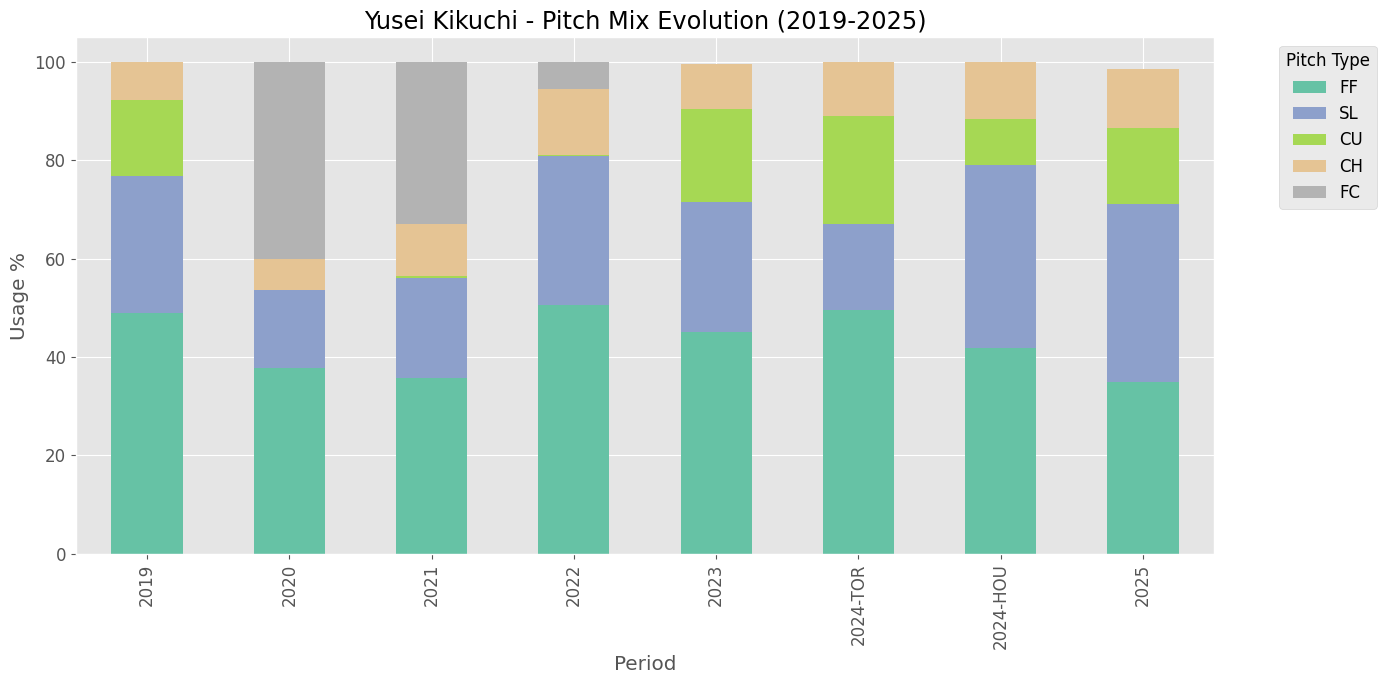


=== Pitch Mix (% usage) ===
pitch_type    FF    SL    CU    CH    FC
period                                  
2019        48.9  28.0  15.4   7.6   0.0
2020        37.7  16.0   0.0   6.3  40.0
2021        35.8  20.2   0.4  10.7  32.9
2022        50.5  30.3   0.3  13.4   5.4
2023        45.2  26.3  18.9   9.1   0.0
2024-TOR    49.6  17.4  22.1  10.9   0.0
2024-HOU    41.8  37.2   9.4  11.6   0.0
2025        34.9  36.2  15.4  12.1   0.0

=== Key Changes ===

  2023 -> 2024-TOR:
    SL: 26.3% -> 17.4% (-8.9%)
    CU: 18.9% -> 22.1% (+3.2%)
    FF: 45.2% -> 49.6% (+4.4%)

  2024-TOR -> 2024-HOU:
    CU: 22.1% -> 9.4% (-12.7%)
    FF: 49.6% -> 41.8% (-7.8%)
    SL: 17.4% -> 37.2% (+19.8%)

  2024-HOU -> 2025:
    FF: 41.8% -> 34.9% (-6.9%)
    CU: 9.4% -> 15.4% (+6.0%)


In [6]:
top_pitches_overall = con.execute("""
    SELECT pitch_type FROM df
    WHERE pitch_type IS NOT NULL
    GROUP BY pitch_type
    HAVING COUNT(*) >= 50
    ORDER BY COUNT(*) DESC
""").df()['pitch_type'].tolist()

mix_pivot = arsenal.pivot_table(index='period', columns='pitch_type', values='pct', fill_value=0)
available_periods = [p for p in PERIOD_ORDER if p in mix_pivot.index]
mix_pivot = mix_pivot.reindex(available_periods)

plot_cols = [col for col in top_pitches_overall if col in mix_pivot.columns]
mix_pivot[plot_cols].plot(kind='bar', stacked=True, figsize=(14, 7), colormap='Set2')
plt.title('Yusei Kikuchi - Pitch Mix Evolution (2019-2025)')
plt.xlabel('Period')
plt.ylabel('Usage %')
plt.legend(title='Pitch Type', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# === Text Summary ===
print('\n=== Pitch Mix (% usage) ===')
print(mix_pivot[plot_cols].round(1).to_string())

print(f'\n=== Key Changes ===')
for pair in [('2023', '2024-TOR'), ('2024-TOR', '2024-HOU'), ('2024-HOU', '2025')]:
    p1, p2 = pair
    if p1 in mix_pivot.index and p2 in mix_pivot.index:
        first = mix_pivot.loc[p1]
        last = mix_pivot.loc[p2]
        diff = (last - first).sort_values()
        changes = [(p, c) for p, c in diff.items() if abs(c) >= 3.0]
        if changes:
            print(f'\n  {p1} -> {p2}:')
            for pitch, change in changes:
                direction = '+' if change > 0 else ''
                print(f'    {pitch}: {first[pitch]:.1f}% -> {last[pitch]:.1f}% ({direction}{change:.1f}%)')

## 5. The Slider Revolution: Toronto vs Houston

菊池のアストロズ移籍後最大の変化はスライダー使用率の劇増（報道では22%→37%）。
使用率・被打率・空振り率・投球位置を詳細に比較

=== Breaking Ball Types ===
pitch_type  cnt
        SL 4503
        FC 1260
        ST    8

Primary slider type: SL

=== SL Analysis by Period ===
  period  pitches  usage_pct  avg_velo  avg_spin  h_break  v_break  whiff_rate  xBA_contact
    2019      736       27.0      86.0    2220.0     -0.3      0.3        24.8        0.304
    2020      127       16.0      83.3    2347.0     -0.1     -0.1        33.9        0.220
    2021      518       20.2      83.2    2387.0     -0.2     -0.2        30.5        0.344
    2022      559       30.3      86.6    2355.0     -0.3      0.2        31.0        0.366
    2023      741       26.3      88.7    2427.0     -0.2      0.3        28.0        0.361
2024-TOR      341       17.4      89.0    2412.0     -0.2      0.3        27.8        0.343
2024-HOU      360       37.1      87.5    2380.0     -0.3      0.2        28.1        0.346
    2025     1121       36.1      87.0    2295.0     -0.2      0.3        23.1        0.344


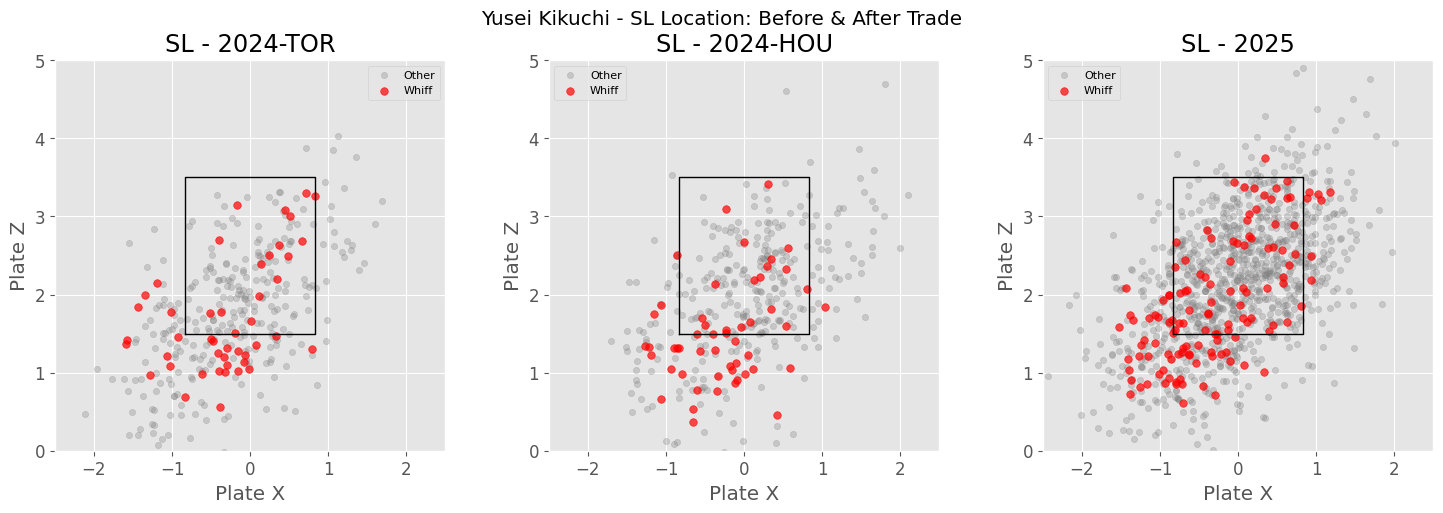

In [7]:
# Identify slider pitch type(s) - could be SL or ST
slider_types = con.execute("""
    SELECT pitch_type, COUNT(*) as cnt
    FROM df
    WHERE pitch_type IN ('SL', 'ST', 'SV', 'FC')
    GROUP BY pitch_type
    ORDER BY cnt DESC
""").df()
print('=== Breaking Ball Types ===')
print(slider_types.to_string(index=False))

slider_type = slider_types.iloc[0]['pitch_type'] if len(slider_types) > 0 else 'SL'
print(f'\nPrimary slider type: {slider_type}')

# Slider analysis by period
sl_analysis = con.execute(f"""
    SELECT
        period,
        COUNT(*) as pitches,
        ROUND(100.0 * COUNT(*) / (SELECT COUNT(*) FROM df d2 WHERE d2.period = df.period), 1) as usage_pct,
        ROUND(AVG(release_speed), 1) as avg_velo,
        ROUND(AVG(release_spin_rate), 0) as avg_spin,
        ROUND(AVG(pfx_x), 1) as h_break,
        ROUND(AVG(pfx_z), 1) as v_break,
        ROUND(100.0 * SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked'
        ) THEN 1 ELSE 0 END) /
        NULLIF(SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked',
            'foul', 'foul_tip', 'foul_bunt',
            'hit_into_play', 'hit_into_play_no_out', 'hit_into_play_score'
        ) THEN 1 ELSE 0 END), 0), 1) as whiff_rate,
        ROUND(AVG(CASE WHEN launch_speed IS NOT NULL THEN estimated_ba_using_speedangle END), 3) as xBA_contact
    FROM df
    WHERE pitch_type = '{slider_type}'
    GROUP BY period
    ORDER BY {PERIOD_SORT}
""").df()

print(f'\n=== {slider_type} Analysis by Period ===')
print(sl_analysis.to_string(index=False))

# Slider location scatter: 2024-TOR vs 2024-HOU vs 2025
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
compare_periods = ['2024-TOR', '2024-HOU', '2025']
for i, period in enumerate(compare_periods):
    sl_data = con.execute(f"""
        SELECT plate_x, plate_z, description
        FROM df
        WHERE pitch_type = '{slider_type}' AND period = '{period}'
          AND plate_x IS NOT NULL AND plate_z IS NOT NULL
    """).df()
    if len(sl_data) > 0:
        whiff_mask = sl_data['description'].isin(['swinging_strike', 'swinging_strike_blocked'])
        axes[i].scatter(sl_data[~whiff_mask]['plate_x'], sl_data[~whiff_mask]['plate_z'],
                        alpha=0.3, s=20, c='gray', label='Other')
        axes[i].scatter(sl_data[whiff_mask]['plate_x'], sl_data[whiff_mask]['plate_z'],
                        alpha=0.7, s=30, c='red', label='Whiff')
    axes[i].plot([-0.83, 0.83, 0.83, -0.83, -0.83],
                 [1.5, 1.5, 3.5, 3.5, 1.5], 'k-', linewidth=1)
    axes[i].set_xlim(-2.5, 2.5)
    axes[i].set_ylim(0, 5)
    axes[i].set_title(f'{slider_type} - {period}')
    axes[i].set_xlabel('Plate X')
    axes[i].set_ylabel('Plate Z')
    axes[i].legend(fontsize=8)
    axes[i].set_aspect('equal')

plt.suptitle(f'Yusei Kikuchi - {slider_type} Location: Before & After Trade')
plt.tight_layout()
plt.show()

## 6. Velocity & Spin Trends

7年間のフォーシーム球速推移と各球種のスピンレート変化

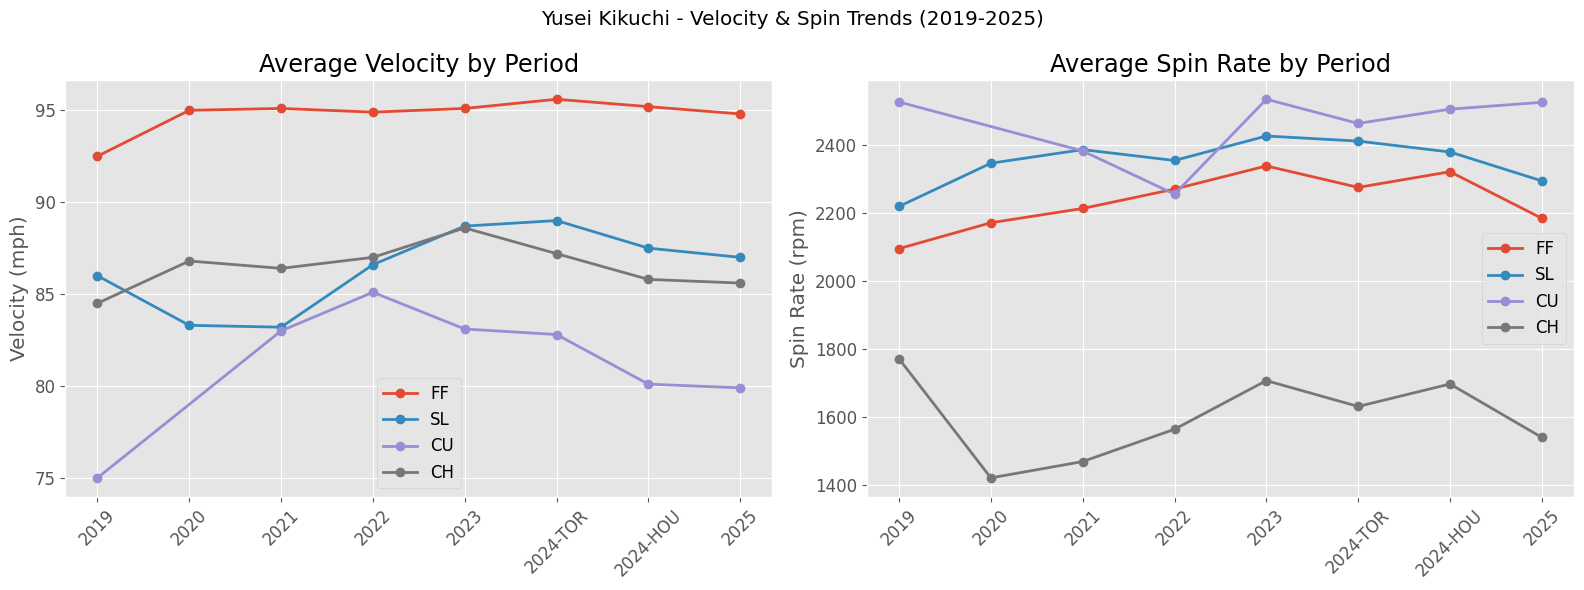


=== Velocity & Spin by Period (Top Pitches) ===

FF:
  period  avg_velo  avg_spin  count
    2019      92.5    2096.0   1286
    2020      95.0    2172.0    300
    2021      95.1    2214.0    917
    2022      94.9    2271.0    931
    2023      95.1    2339.0   1274
2024-HOU      95.2    2322.0    405
2024-TOR      95.6    2276.0    969
    2025      94.8    2185.0   1081

SL:
  period  avg_velo  avg_spin  count
    2019      86.0    2220.0    736
    2020      83.3    2347.0    127
    2021      83.2    2387.0    518
    2022      86.6    2355.0    559
    2023      88.7    2427.0    741
2024-HOU      87.5    2380.0    360
2024-TOR      89.0    2412.0    341
    2025      87.0    2295.0   1121

CU:
  period  avg_velo  avg_spin  count
    2019      75.0    2527.0    406
    2021      83.0    2383.0     10
    2022      85.1    2256.0      6
    2023      83.1    2535.0    533
2024-HOU      80.1    2506.0     91
2024-TOR      82.8    2464.0    432
    2025      79.9    2526.0    476


In [8]:
velo_by_period = con.execute("""
    SELECT
        period,
        pitch_type,
        ROUND(AVG(release_speed), 1) as avg_velo,
        ROUND(AVG(release_spin_rate), 0) as avg_spin,
        COUNT(*) as count
    FROM df
    WHERE pitch_type IS NOT NULL
    GROUP BY period, pitch_type
    ORDER BY period
""").df()

top_pitches = con.execute("""
    SELECT pitch_type FROM df
    WHERE pitch_type IS NOT NULL
    GROUP BY pitch_type
    ORDER BY COUNT(*) DESC
    LIMIT 4
""").df()['pitch_type'].tolist()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
period_idx = {p: i for i, p in enumerate(PERIOD_ORDER)}
for pitch in top_pitches:
    data = velo_by_period[velo_by_period['pitch_type'] == pitch].copy()
    data['idx'] = data['period'].map(period_idx)
    data = data.dropna(subset=['idx']).sort_values('idx')
    if len(data) >= 2:
        axes[0].plot(data['period'], data['avg_velo'], marker='o', label=pitch, linewidth=2)
        axes[1].plot(data['period'], data['avg_spin'], marker='o', label=pitch, linewidth=2)

for ax in axes:
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
axes[0].set_title('Average Velocity by Period')
axes[0].set_ylabel('Velocity (mph)')
axes[1].set_title('Average Spin Rate by Period')
axes[1].set_ylabel('Spin Rate (rpm)')
plt.suptitle('Yusei Kikuchi - Velocity & Spin Trends (2019-2025)')
plt.tight_layout()
plt.show()

# === Text Summary ===
print('\n=== Velocity & Spin by Period (Top Pitches) ===')
for pitch in top_pitches:
    data = velo_by_period[velo_by_period['pitch_type'] == pitch]
    available = data[data['period'].isin(PERIOD_ORDER)]
    print(f'\n{pitch}:')
    print(available[['period', 'avg_velo', 'avg_spin', 'count']].to_string(index=False))

## 7. Fatigue Pattern: Inning-by-Inning Velocity

イニングが進むにつれて球速がどう変化するか。2025の33先発を支えたスタミナを検証

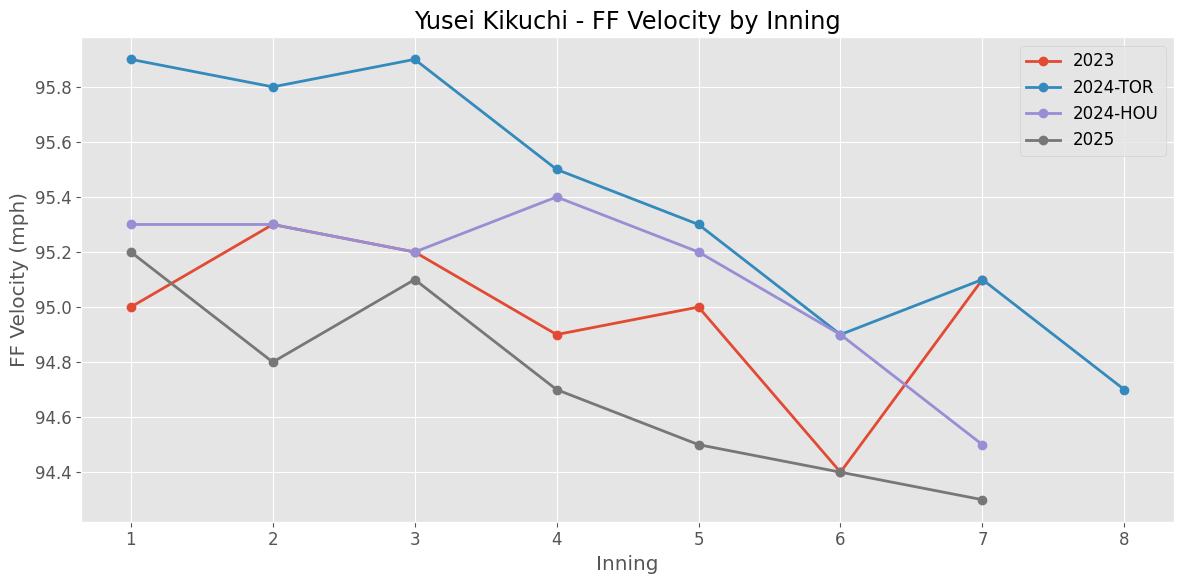


=== FF Velocity by Inning ===
period  2023  2024-TOR  2024-HOU  2025
inning                                
1       95.0      95.9      95.3  95.2
2       95.3      95.8      95.3  94.8
3       95.2      95.9      95.2  95.1
4       94.9      95.5      95.4  94.7
5       95.0      95.3      95.2  94.5
6       94.4      94.9      94.9  94.4
7       95.1      95.1      94.5  94.3
8        NaN      94.7       NaN   NaN

=== Velocity Drop (1st -> last inning) ===
  2023: 95.0 -> 95.1 (inn 7) = +0.1 mph
  2024-TOR: 95.9 -> 94.7 (inn 8) = -1.2 mph
  2024-HOU: 95.3 -> 94.5 (inn 7) = -0.8 mph
  2025: 95.2 -> 94.3 (inn 7) = -0.9 mph


In [9]:
ff_type = 'FF' if 'FF' in top_pitches else top_pitches[0]
fatigue_periods = ['2023', '2024-TOR', '2024-HOU', '2025']

fatigue = con.execute(f"""
    SELECT
        period,
        inning,
        ROUND(AVG(release_speed), 1) as avg_velo,
        COUNT(*) as pitches
    FROM df
    WHERE pitch_type = '{ff_type}' AND inning <= 8
      AND period IN ('2023', '2024-TOR', '2024-HOU', '2025')
    GROUP BY period, inning
    HAVING COUNT(*) >= 5
    ORDER BY period, inning
""").df()

fig, ax = plt.subplots(figsize=(12, 6))
for period in fatigue_periods:
    data = fatigue[fatigue['period'] == period]
    if len(data) > 0:
        ax.plot(data['inning'], data['avg_velo'], marker='o', label=period, linewidth=2)

ax.set_xlabel('Inning')
ax.set_ylabel(f'{ff_type} Velocity (mph)')
ax.set_title(f'Yusei Kikuchi - {ff_type} Velocity by Inning')
ax.set_xticks(range(1, 9))
ax.legend()
plt.tight_layout()
plt.show()

# === Text Summary ===
print(f'\n=== {ff_type} Velocity by Inning ===')
fatigue_pivot = fatigue.pivot_table(index='inning', columns='period', values='avg_velo')
fatigue_pivot = fatigue_pivot.reindex(columns=fatigue_periods)
print(fatigue_pivot.to_string())

print(f'\n=== Velocity Drop (1st -> last inning) ===')
for period in fatigue_periods:
    data = fatigue[fatigue['period'] == period]
    if len(data) >= 2:
        first_velo = data.iloc[0]['avg_velo']
        last_velo = data.iloc[-1]['avg_velo']
        last_inn = int(data.iloc[-1]['inning'])
        drop = last_velo - first_velo
        print(f'  {period}: {first_velo} -> {last_velo} (inn {last_inn}) = {drop:+.1f} mph')

## 8. Whiff Rate (空振り率)

空振り率 = 空振り数 / スイング総数。アストロズ以降の変化に注目

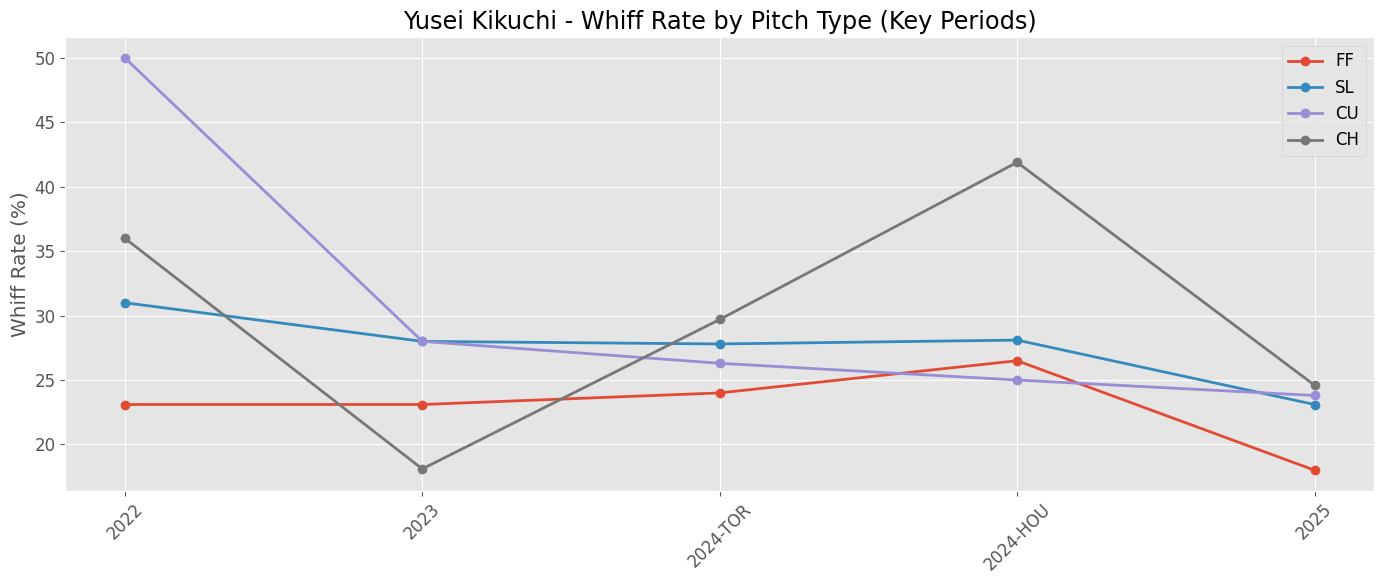


=== Whiff Rate by Pitch Type (Key Periods) ===
period      2022  2023  2024-TOR  2024-HOU  2025
pitch_type                                      
CH          36.0  18.1      29.7      41.9  24.6
CU          50.0  28.0      26.3      25.0  23.8
FC          23.4   NaN       NaN       NaN   NaN
FF          23.1  23.1      24.0      26.5  18.0
SI           NaN  33.3       NaN       NaN  14.3
SL          31.0  28.0      27.8      28.1  23.1
ST           NaN   NaN       NaN       NaN  50.0


In [10]:
whiff = con.execute(f"""
    SELECT
        period,
        pitch_type,
        COUNT(*) as total_pitches,
        SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked'
        ) THEN 1 ELSE 0 END) as whiffs,
        SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked',
            'foul', 'foul_tip', 'foul_bunt',
            'hit_into_play', 'hit_into_play_no_out', 'hit_into_play_score'
        ) THEN 1 ELSE 0 END) as total_swings,
        ROUND(100.0 * SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked'
        ) THEN 1 ELSE 0 END) /
        NULLIF(SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked',
            'foul', 'foul_tip', 'foul_bunt',
            'hit_into_play', 'hit_into_play_no_out', 'hit_into_play_score'
        ) THEN 1 ELSE 0 END), 0), 1) as whiff_rate
    FROM df
    WHERE pitch_type IS NOT NULL
    GROUP BY period, pitch_type
    ORDER BY {PERIOD_SORT}, total_pitches DESC
""").df()

fig, ax = plt.subplots(figsize=(14, 6))
period_idx = {p: i for i, p in enumerate(KEY_PERIODS)}
for pitch in top_pitches:
    data = whiff[(whiff['pitch_type'] == pitch) & (whiff['period'].isin(KEY_PERIODS))].copy()
    data['idx'] = data['period'].map(period_idx)
    data = data.dropna(subset=['idx']).sort_values('idx')
    if len(data) >= 2:
        ax.plot(data['period'], data['whiff_rate'], marker='o', label=pitch, linewidth=2)

ax.set_ylabel('Whiff Rate (%)')
ax.set_title('Yusei Kikuchi - Whiff Rate by Pitch Type (Key Periods)')
ax.tick_params(axis='x', rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

# === Text Summary ===
print('\n=== Whiff Rate by Pitch Type (Key Periods) ===')
whiff_key = whiff[whiff['period'].isin(KEY_PERIODS)]
whiff_pivot = whiff_key.pivot_table(index='pitch_type', columns='period', values='whiff_rate')
whiff_pivot = whiff_pivot.reindex(columns=KEY_PERIODS)
print(whiff_pivot.round(1).to_string())

## 9. Two-Strike Strategy

2ストライクからの「決め球」がどう変わったか

In [11]:
two_strike = con.execute(f"""
    SELECT
        period,
        pitch_type,
        COUNT(*) as pitches,
        ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER(PARTITION BY period), 1) as pct,
        ROUND(100.0 * SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked'
        ) THEN 1 ELSE 0 END) /
        NULLIF(SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked',
            'foul', 'foul_tip', 'foul_bunt',
            'hit_into_play', 'hit_into_play_no_out', 'hit_into_play_score'
        ) THEN 1 ELSE 0 END), 0), 1) as whiff_rate
    FROM df
    WHERE strikes = 2 AND pitch_type IS NOT NULL
      AND period IN ('2023', '2024-TOR', '2024-HOU', '2025')
    GROUP BY period, pitch_type
    ORDER BY {PERIOD_SORT}, pitches DESC
""").df()

print('=== Two-Strike Pitch Selection ===')
for period in ['2023', '2024-TOR', '2024-HOU', '2025']:
    data = two_strike[two_strike['period'] == period].head(5)
    if len(data) > 0:
        print(f'\n--- {period} ({TEAM_MAP.get(period, "?")}) ---')
        print(data[['pitch_type', 'pitches', 'pct', 'whiff_rate']].to_string(index=False))

=== Two-Strike Pitch Selection ===

--- 2023 (TOR) ---
pitch_type  pitches  pct  whiff_rate
        FF      336 39.6        19.9
        SL      312 36.8        29.4
        CU      130 15.3        31.0
        CH       64  7.5        14.3
        SI        5  0.6        40.0

--- 2024-TOR (TOR) ---
pitch_type  pitches  pct  whiff_rate
        FF      233 39.7        22.7
        SL      150 25.6        29.7
        CU      112 19.1        31.2
        CH       92 15.7        39.5

--- 2024-HOU (HOU) ---
pitch_type  pitches  pct  whiff_rate
        FF      144 42.9        21.6
        SL      123 36.6        33.8
        CH       37 11.0        44.4
        CU       32  9.5        26.7

--- 2025 (LAA) ---
pitch_type  pitches  pct  whiff_rate
        FF      351 36.7        15.0
        SL      295 30.8        27.2
        CH      160 16.7        25.5
        CU      141 14.7        23.9
        SI        7  0.7         0.0


## 10. Batted Ball Results (被打球)

打たれた時の打球品質を期間別に比較。xwOBA, Hard Hit%, Exit Velocity

In [12]:
batted = con.execute(f"""
    SELECT
        period,
        COUNT(*) as batted_balls,
        ROUND(AVG(launch_speed), 1) as avg_exit_velo,
        ROUND(AVG(launch_angle), 1) as avg_launch_angle,
        ROUND(100.0 * SUM(CASE WHEN launch_speed >= 95 THEN 1 ELSE 0 END) / COUNT(*), 1) as hard_hit_pct,
        ROUND(AVG(estimated_ba_using_speedangle), 3) as avg_xBA,
        ROUND(AVG(estimated_woba_using_speedangle), 3) as avg_xwOBA
    FROM df
    WHERE launch_speed IS NOT NULL
    GROUP BY period
    ORDER BY {PERIOD_SORT}
""").df()

print('=== Batted Ball Results by Period ===')
print(batted.to_string(index=False))

# By pitch type (key periods)
batted_by_pitch = con.execute(f"""
    SELECT
        period,
        pitch_type,
        COUNT(*) as batted_balls,
        ROUND(AVG(launch_speed), 1) as avg_exit_velo,
        ROUND(AVG(estimated_ba_using_speedangle), 3) as avg_xBA
    FROM df
    WHERE launch_speed IS NOT NULL AND pitch_type IS NOT NULL
      AND period IN ('2023', '2024-TOR', '2024-HOU', '2025')
    GROUP BY period, pitch_type
    HAVING COUNT(*) >= 10
    ORDER BY {PERIOD_SORT}, batted_balls DESC
""").df()

print('\n=== Batted Ball by Pitch Type (min 10 BIP) ===')
for period in ['2023', '2024-TOR', '2024-HOU', '2025']:
    data = batted_by_pitch[batted_by_pitch['period'] == period]
    if len(data) > 0:
        print(f'\n--- {period} ---')
        print(data[['pitch_type', 'batted_balls', 'avg_exit_velo', 'avg_xBA']].to_string(index=False))

=== Batted Ball Results by Period ===
  period  batted_balls  avg_exit_velo  avg_launch_angle  hard_hit_pct  avg_xBA  avg_xwOBA
    2019           818           84.5              16.4          28.7    0.336      0.384
    2020           221           83.3              12.9          21.7    0.308      0.321
    2021           832           84.3              13.2          28.4    0.350      0.419
    2022           566           83.6              16.2          26.9    0.365      0.456
    2023           903           83.5              17.1          25.9    0.338      0.400
2024-TOR           647           83.6              21.2          26.9    0.341      0.398
2024-HOU           304           82.1              17.2          25.3    0.318      0.382
    2025          1062           83.5              19.7          25.1    0.330      0.385

=== Batted Ball by Pitch Type (min 10 BIP) ===

--- 2023 ---
pitch_type  batted_balls  avg_exit_velo  avg_xBA
        FF           380           82.9  

## 11. Release Point Analysis

アストロズ移籍後にリリースポイントが変わったか？メカニクスの変化を数値で確認

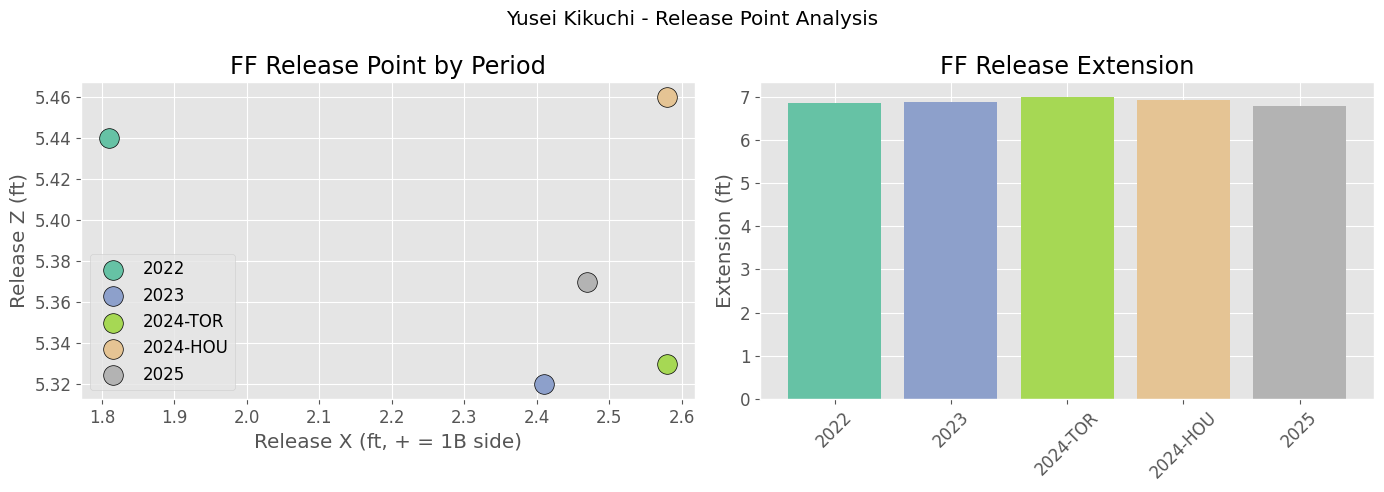


=== FF Release Point by Period ===
  period  avg_rel_x  avg_rel_z  avg_extension  pitches
    2022       1.81       5.44           6.86      931
    2023       2.41       5.32           6.89     1274
2024-TOR       2.58       5.33           6.99      969
2024-HOU       2.58       5.46           6.94      405
    2025       2.47       5.37           6.79     1081


In [13]:
release = con.execute(f"""
    SELECT
        period,
        pitch_type,
        ROUND(AVG(release_pos_x), 2) as avg_rel_x,
        ROUND(AVG(release_pos_z), 2) as avg_rel_z,
        ROUND(AVG(release_extension), 2) as avg_extension,
        COUNT(*) as pitches
    FROM df
    WHERE pitch_type IS NOT NULL
      AND release_pos_x IS NOT NULL
      AND period IN ('2022', '2023', '2024-TOR', '2024-HOU', '2025')
    GROUP BY period, pitch_type
    HAVING COUNT(*) >= 20
    ORDER BY {PERIOD_SORT}, pitches DESC
""").df()

ff_release = release[release['pitch_type'] == ff_type]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = plt.cm.Set2(np.linspace(0, 1, len(KEY_PERIODS)))
for i, period in enumerate(KEY_PERIODS):
    data = ff_release[ff_release['period'] == period]
    if len(data) > 0:
        axes[0].scatter(data['avg_rel_x'], data['avg_rel_z'], s=200, c=[colors[i]],
                       label=period, zorder=5, edgecolors='black')

axes[0].set_xlabel('Release X (ft, + = 1B side)')
axes[0].set_ylabel('Release Z (ft)')
axes[0].set_title(f'{ff_type} Release Point by Period')
axes[0].legend()

# Extension comparison
ext_data = ff_release[['period', 'avg_extension']].set_index('period')
ext_data = ext_data.reindex([p for p in KEY_PERIODS if p in ext_data.index])
if len(ext_data) > 0:
    axes[1].bar(ext_data.index, ext_data['avg_extension'], color=colors[:len(ext_data)])
    axes[1].set_ylabel('Extension (ft)')
    axes[1].set_title(f'{ff_type} Release Extension')
    axes[1].tick_params(axis='x', rotation=45)

plt.suptitle('Yusei Kikuchi - Release Point Analysis')
plt.tight_layout()
plt.show()

# === Text Summary ===
print(f'\n=== {ff_type} Release Point by Period ===')
print(ff_release[['period', 'avg_rel_x', 'avg_rel_z', 'avg_extension', 'pitches']].to_string(index=False))

## 12. Pitch Movement Profile

各球種の変化量（水平/垂直）を期間別に比較。
投手の視点: pfx_x(+)=アーム側, pfx_z(+)=上方向（単位: inches）

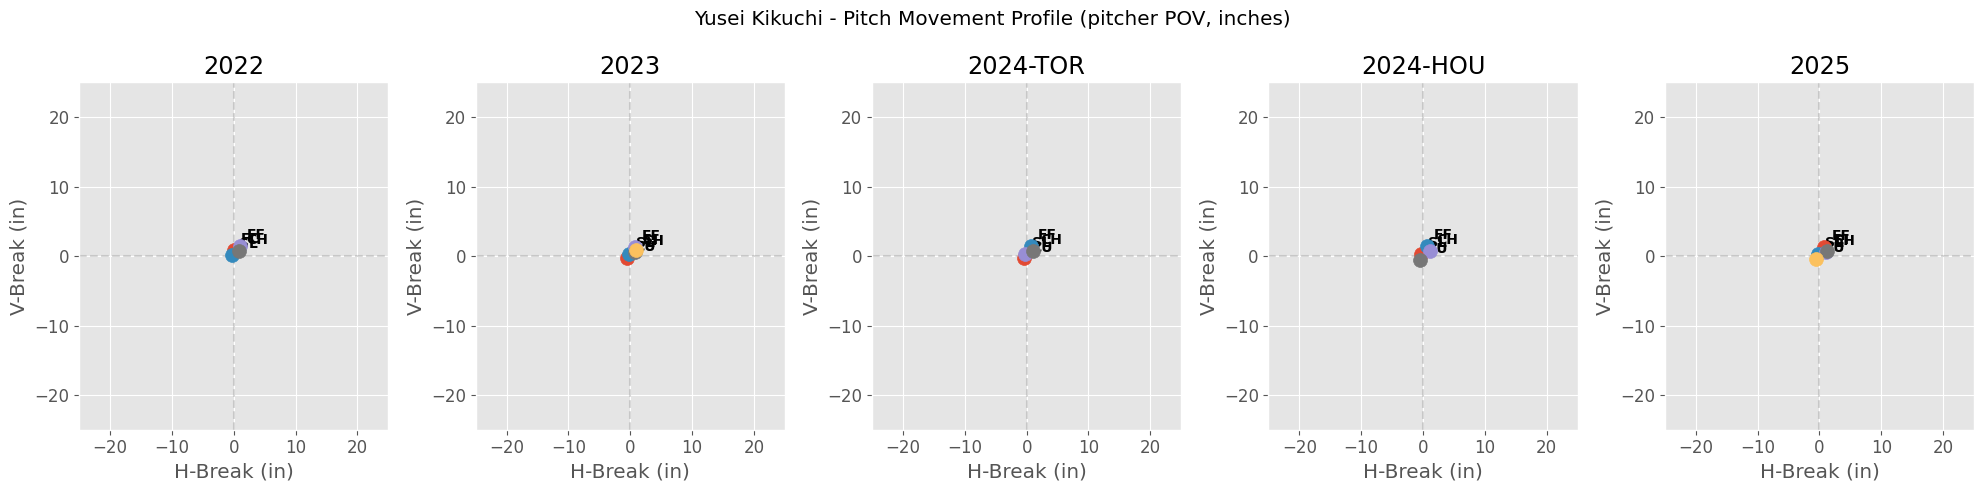


=== Pitch Movement by Period (inches) ===

--- 2022 ---
pitch_type  h_break  v_break  pitches
        FF      1.0      1.4      931
        SL     -0.3      0.2      559
        CH      0.9      0.7      247
        FC      0.0      0.9       99

--- 2023 ---
pitch_type  h_break  v_break  pitches
        FF      0.8      1.3     1274
        SL     -0.2      0.3      741
        CU     -0.5     -0.3      533
        CH      0.7      0.6      257

--- 2024-TOR ---
pitch_type  h_break  v_break  pitches
        FF      0.6      1.4      969
        CU     -0.4     -0.4      432
        SL     -0.2      0.3      341
        CH      1.0      0.7      213

--- 2024-HOU ---
pitch_type  h_break  v_break  pitches
        FF      0.7      1.4      405
        SL     -0.3      0.2      360
        CH      1.1      0.8      112
        CU     -0.5     -0.6       91

--- 2025 ---
pitch_type  h_break  v_break  pitches
        SL     -0.2      0.3     1121
        FF      0.8      1.3     1081
     

In [14]:
fig, axes = plt.subplots(1, len(KEY_PERIODS), figsize=(4*len(KEY_PERIODS), 5))

for i, period in enumerate(KEY_PERIODS):
    pitch_data = con.execute(f"""
        SELECT
            pitch_type,
            AVG(pfx_x) as h_break,
            AVG(pfx_z) as v_break,
            COUNT(*) as cnt
        FROM df
        WHERE period = '{period}'
          AND pitch_type IS NOT NULL
          AND pfx_x IS NOT NULL
        GROUP BY pitch_type
        HAVING COUNT(*) >= 10
    """).df()
    for _, row in pitch_data.iterrows():
        axes[i].scatter(row['h_break'], row['v_break'], s=100, zorder=5)
        axes[i].annotate(row['pitch_type'], (row['h_break'], row['v_break']),
                        fontsize=10, fontweight='bold',
                        xytext=(5, 5), textcoords='offset points')
    axes[i].axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    axes[i].axvline(x=0, color='gray', linestyle='--', alpha=0.3)
    axes[i].set_xlabel('H-Break (in)')
    axes[i].set_ylabel('V-Break (in)')
    axes[i].set_title(period)
    axes[i].set_xlim(-25, 25)
    axes[i].set_ylim(-25, 25)

plt.suptitle('Yusei Kikuchi - Pitch Movement Profile (pitcher POV, inches)')
plt.tight_layout()
plt.show()

# === Text Summary ===
movement = con.execute(f"""
    SELECT
        period,
        pitch_type,
        ROUND(AVG(pfx_x), 1) as h_break,
        ROUND(AVG(pfx_z), 1) as v_break,
        COUNT(*) as pitches
    FROM df
    WHERE pitch_type IS NOT NULL AND pfx_x IS NOT NULL
      AND period IN ('2022', '2023', '2024-TOR', '2024-HOU', '2025')
    GROUP BY period, pitch_type
    HAVING COUNT(*) >= 20
    ORDER BY {PERIOD_SORT}, pitches DESC
""").df()

print('\n=== Pitch Movement by Period (inches) ===')
for period in KEY_PERIODS:
    data = movement[movement['period'] == period]
    if len(data) > 0:
        print(f'\n--- {period} ---')
        print(data[['pitch_type', 'h_break', 'v_break', 'pitches']].to_string(index=False))

## 13. Left/Right Batter Splits

左投手として、右打者・左打者への投球パターンの違い

In [15]:
lr_arsenal = con.execute(f"""
    SELECT
        period,
        stand,
        pitch_type,
        COUNT(*) as count,
        ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER(PARTITION BY period, stand), 1) as pct,
        ROUND(100.0 * SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked'
        ) THEN 1 ELSE 0 END) /
        NULLIF(SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked',
            'foul', 'foul_tip', 'foul_bunt',
            'hit_into_play', 'hit_into_play_no_out', 'hit_into_play_score'
        ) THEN 1 ELSE 0 END), 0), 1) as whiff_rate
    FROM df
    WHERE pitch_type IS NOT NULL
      AND period IN ('2023', '2024-TOR', '2024-HOU', '2025')
    GROUP BY period, stand, pitch_type
    HAVING COUNT(*) >= 10
    ORDER BY {PERIOD_SORT}, stand, count DESC
""").df()

print('=== Pitch Usage & Whiff Rate by Batter Side ===')
for period in ['2023', '2024-TOR', '2024-HOU', '2025']:
    print(f'\n=== {period} ({TEAM_MAP.get(period, "?")}) ===')
    for side in ['L', 'R']:
        data = lr_arsenal[(lr_arsenal['period'] == period) & (lr_arsenal['stand'] == side)]
        if len(data) > 0:
            print(f'\n  vs {side}HB:')
            print(data[['pitch_type', 'count', 'pct', 'whiff_rate']].to_string(index=False))

# Batted ball by side
lr_batted = con.execute(f"""
    SELECT
        period,
        stand,
        COUNT(*) as batted_balls,
        ROUND(AVG(launch_speed), 1) as avg_exit_velo,
        ROUND(AVG(estimated_woba_using_speedangle), 3) as avg_xwOBA,
        ROUND(100.0 * SUM(CASE WHEN launch_speed >= 95 THEN 1 ELSE 0 END) / COUNT(*), 1) as hard_hit_pct
    FROM df
    WHERE launch_speed IS NOT NULL
      AND period IN ('2023', '2024-TOR', '2024-HOU', '2025')
    GROUP BY period, stand
    ORDER BY {PERIOD_SORT}, stand
""").df()

print('\n=== Batted Ball by Batter Side ===')
print(lr_batted.to_string(index=False))

=== Pitch Usage & Whiff Rate by Batter Side ===

=== 2023 (TOR) ===

  vs LHB:
pitch_type  count  pct  whiff_rate
        FF    285 51.3        21.7
        SL    201 36.2        25.7
        CU     70 12.6        31.0

  vs RHB:
pitch_type  count  pct  whiff_rate
        FF    989 44.0        23.5
        SL    540 24.0        28.8
        CU    463 20.6        27.6
        CH    254 11.3        18.1

=== 2024-TOR (TOR) ===

  vs LHB:
pitch_type  count  pct  whiff_rate
        FF    159 46.1        28.2
        SL    113 32.8        36.7
        CU     73 21.2        27.8

  vs RHB:
pitch_type  count  pct  whiff_rate
        FF    810 50.3        23.3
        CU    359 22.3        25.9
        SL    228 14.2        24.2
        CH    213 13.2        29.7

=== 2024-HOU (HOU) ===

  vs LHB:
pitch_type  count  pct  whiff_rate
        SL     98 47.8        18.5
        FF     92 44.9        14.6
        CU     15  7.3        14.3

  vs RHB:
pitch_type  count  pct  whiff_rate
        FF   

## 14. Time Through Order (打順周り別)

1巡目/2巡目/3巡目で打たれ方がどう変わるか。2025の33先発達成の裏にある3巡目対策

In [16]:
tto = con.execute(f"""
    WITH batter_pa AS (
        SELECT
            period,
            game_pk,
            batter,
            at_bat_number,
            DENSE_RANK() OVER(PARTITION BY game_pk, batter ORDER BY at_bat_number) as pa_num
        FROM df
        GROUP BY period, game_pk, batter, at_bat_number
    ),
    tto_tagged AS (
        SELECT
            d.*,
            CASE
                WHEN b.pa_num = 1 THEN '1st'
                WHEN b.pa_num = 2 THEN '2nd'
                ELSE '3rd+'
            END as tto
        FROM df d
        JOIN batter_pa b ON d.game_pk = b.game_pk AND d.batter = b.batter AND d.at_bat_number = b.at_bat_number
        WHERE d.period IN ('2023', '2024-TOR', '2024-HOU', '2025')
    )
    SELECT
        period,
        tto,
        COUNT(*) as pitches,
        ROUND(100.0 * SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked'
        ) THEN 1 ELSE 0 END) /
        NULLIF(SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked',
            'foul', 'foul_tip', 'foul_bunt',
            'hit_into_play', 'hit_into_play_no_out', 'hit_into_play_score'
        ) THEN 1 ELSE 0 END), 0), 1) as whiff_rate
    FROM tto_tagged
    GROUP BY period, tto
    ORDER BY {PERIOD_SORT}, tto
""").df()

print('=== Whiff Rate by Time Through Order ===')
tto_pivot = tto.pivot_table(index='tto', columns='period', values='whiff_rate')
tto_pivot = tto_pivot.reindex(columns=['2023', '2024-TOR', '2024-HOU', '2025'])
print(tto_pivot.round(1).to_string())

# Batted ball quality by TTO
tto_batted = con.execute(f"""
    WITH batter_pa AS (
        SELECT
            period,
            game_pk,
            batter,
            at_bat_number,
            DENSE_RANK() OVER(PARTITION BY game_pk, batter ORDER BY at_bat_number) as pa_num
        FROM df
        GROUP BY period, game_pk, batter, at_bat_number
    ),
    tto_tagged AS (
        SELECT
            d.*,
            CASE
                WHEN b.pa_num = 1 THEN '1st'
                WHEN b.pa_num = 2 THEN '2nd'
                ELSE '3rd+'
            END as tto
        FROM df d
        JOIN batter_pa b ON d.game_pk = b.game_pk AND d.batter = b.batter AND d.at_bat_number = b.at_bat_number
        WHERE d.period IN ('2023', '2024-TOR', '2024-HOU', '2025')
    )
    SELECT
        period,
        tto,
        COUNT(*) as batted_balls,
        ROUND(AVG(launch_speed), 1) as avg_exit_velo,
        ROUND(AVG(estimated_woba_using_speedangle), 3) as avg_xwOBA
    FROM tto_tagged
    WHERE launch_speed IS NOT NULL
    GROUP BY period, tto
    ORDER BY {PERIOD_SORT}, tto
""").df()

print('\n=== Batted Ball by Time Through Order ===')
for period in ['2023', '2024-TOR', '2024-HOU', '2025']:
    data = tto_batted[tto_batted['period'] == period]
    if len(data) > 0:
        print(f'\n--- {period} ---')
        print(data[['tto', 'batted_balls', 'avg_exit_velo', 'avg_xwOBA']].to_string(index=False))

=== Whiff Rate by Time Through Order ===
period  2023  2024-TOR  2024-HOU  2025
tto                                   
1st     26.0      28.8      25.8  20.9
2nd     26.0      23.8      31.9  23.0
3rd+    22.0      22.9      26.8  20.5

=== Batted Ball by Time Through Order ===

--- 2023 ---
 tto  batted_balls  avg_exit_velo  avg_xwOBA
 1st           345           84.1      0.416
 2nd           391           83.1      0.385
3rd+           167           83.2      0.399

--- 2024-TOR ---
 tto  batted_balls  avg_exit_velo  avg_xwOBA
 1st           258           83.9      0.393
 2nd           247           83.6      0.379
3rd+           142           83.0      0.440

--- 2024-HOU ---
 tto  batted_balls  avg_exit_velo  avg_xwOBA
 1st           117           83.7      0.393
 2nd           114           81.6      0.367
3rd+            73           80.2      0.386

--- 2025 ---
 tto  batted_balls  avg_exit_velo  avg_xwOBA
 1st           414           84.4      0.405
 2nd           387         

## 15. Summary

In [17]:
print('=' * 65)
print('YUSEI KIKUCHI CAREER EVOLUTION SUMMARY (2019-2025)')
print('=' * 65)

# Career arc
print('\n[Career Arc]')
for _, row in summary.iterrows():
    team = TEAM_MAP.get(row['period'], '?')
    print(f'  {row["period"]} ({team}): {int(row["games"])} GS, {int(row["pitches"]):,} pitches, avg {row["avg_velo"]} mph')

# Slider revolution
print(f'\n[Slider Revolution: {slider_type} Usage]')
for period in PERIOD_ORDER:
    sl_data = arsenal[(arsenal['period'] == period) & (arsenal['pitch_type'] == slider_type)]
    if len(sl_data) > 0:
        pct = sl_data.iloc[0]['pct']
        print(f'  {period}: {pct}%')

# FF velocity
print(f'\n[Fastball Velocity ({ff_type})]')
ff_data = velo_by_period[velo_by_period['pitch_type'] == ff_type]
for _, row in ff_data.iterrows():
    if row['period'] in PERIOD_ORDER:
        print(f'  {row["period"]}: {row["avg_velo"]} mph')

# Best whiff pitch
print(f'\n[Best Whiff Rate Pitch]')
for period in KEY_PERIODS:
    period_whiff = whiff[(whiff['period'] == period) & (whiff['total_swings'] >= 20)]
    if len(period_whiff) > 0:
        best = period_whiff.loc[period_whiff['whiff_rate'].idxmax()]
        print(f'  {period}: {best["pitch_type"]} ({best["whiff_rate"]}%)')

# Batted ball
print(f'\n[Batted Ball Quality]')
for _, row in batted.iterrows():
    print(f'  {row["period"]}: xwOBA {row["avg_xwOBA"]}, Hard Hit {row["hard_hit_pct"]}%')

print('\n' + '=' * 65)

YUSEI KIKUCHI CAREER EVOLUTION SUMMARY (2019-2025)

[Career Arc]
  2019 (SEA): 32 GS, 2,721 pitches, avg 87.3 mph
  2020 (SEA): 9 GS, 795 pitches, avg 91.4 mph
  2021 (SEA): 29 GS, 2,562 pitches, avg 90.5 mph
  2022 (TOR): 32 GS, 1,844 pitches, avg 91.1 mph
  2023 (TOR): 32 GS, 2,818 pitches, avg 90.5 mph
  2024-TOR (TOR): 22 GS, 1,955 pitches, avg 90.7 mph
  2024-HOU (HOU): 10 GS, 971 pitches, avg 89.9 mph
  2025 (LAA): 33 GS, 3,109 pitches, avg 88.5 mph

[Slider Revolution: SL Usage]
  2019: 28.0%
  2020: 16.0%
  2021: 20.2%
  2022: 30.3%
  2023: 26.3%
  2024-TOR: 17.4%
  2024-HOU: 37.2%
  2025: 36.2%

[Fastball Velocity (FF)]
  2019: 92.5 mph
  2020: 95.0 mph
  2021: 95.1 mph
  2022: 94.9 mph
  2023: 95.1 mph
  2024-HOU: 95.2 mph
  2024-TOR: 95.6 mph
  2025: 94.8 mph

[Best Whiff Rate Pitch]
  2022: CH (36.0%)
  2023: SL (28.0%)
  2024-TOR: CH (29.7%)
  2024-HOU: CH (41.9%)
  2025: CH (24.6%)

[Batted Ball Quality]
  2019: xwOBA 0.384, Hard Hit 28.7%
  2020: xwOBA 0.321, Hard Hit 21